In [1]:
# process the data


# 3D mask proposal

In [1]:
import numpy as np
import torch
from scripts.utils import load_ply
from pytorch3d.structures import Meshes,Pointclouds
from pytorch3d.renderer import Textures
from pytorch3d.io import load_obj
from point_sam.build_model import build_point_sam
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pytorch3d.ops as ops
from pytorch3d.ops import sample_farthest_points
from utils.nms import apply_pointwise_nms,visualize_point_clouds_with_masks
from mask_proposal import  mask_proposal,mask_proposal_v2,batch_mask_proposal
from utils.render import render_all_angles_pc,render_single_view,project_3d_to_2d
import glob
from point_sam.build_model import build_point_sam
import numpy as np
import torch
from scripts.utils import load_ply
from pytorch3d.structures import Meshes
from pytorch3d.renderer import Textures
from pytorch3d.io import load_obj
# Use glob to access all files in the directory
from transformers import AutoProcessor, AutoModelForCausalLM
import random
import os
from utils.inference_florence import run_florence2
from PIL import Image
import cv2
import supervision as sv
import open3d as o3d

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_prediction_data(filename):
    with open(filename, 'r') as file:
        return [{'file': parts[0], 'prediction': int(parts[1]), 'confidence': float(parts[2])}
                for line in file if len(parts := line.strip().split()) == 3]

def normalize_point_cloud(xyz):
    centroid = np.mean(xyz, axis=0)
    xyz_centered = xyz - centroid
    furthest_distance = np.max(np.sqrt(np.sum(xyz_centered**2, axis=1)))
    return xyz_centered / furthest_distance

def process_scene(scene_id, scene_path, mask_info_path, model, output_dir,mask_infos):
    pcd = o3d.io.read_point_cloud(scene_path)
    xyz = np.asarray(pcd.points)
    rgb = np.asarray(pcd.colors) * 255

#     rotation_matrix = o3d.geometry.get_rotation_matrix_from_xyz((-np.pi/2, 0, 0))

# # Rotate point cloud

# # Rotate mesh
#     pcd = pcd.rotate(rotation_matrix, center=(0, 0, 0)) 
    
    for idx, mask_info in enumerate(mask_infos):
        mask = np.loadtxt(os.path.join(os.path.dirname(mask_info_path), mask_info['file'])).astype(bool)
        obj_xyz = normalize_point_cloud(xyz[mask])
        obj_rgb = rgb[mask]
        
        obj_xyz_tensor = torch.tensor(obj_xyz).to(device).float()
        obj_rgb_tensor = torch.tensor(obj_rgb).to(device).float()

         
        obj_pcd = Pointclouds(points=[obj_xyz_tensor], features=[obj_rgb_tensor])
        obj_xyz_tensor = obj_xyz_tensor.unsqueeze(0)
        obj_rgb_tensor = obj_rgb_tensor.unsqueeze(0)
        top_k_masks, _, _ = mask_proposal(obj_xyz_tensor, obj_rgb_tensor, NUM_PROMPTS, model)
        #instance_pcd
        img_dir, pc_depth, screen_coords, num_views, cameras = render_all_angles_pc(obj_pcd, os.path.join(output_dir, str(idx)), device)
        # save top_k_masks,pc_depth,screen_coords as pt
        # save obj_xyz as np
        # make a new directoy under the os.path.join(output_dir, str(idx)) called ins_info
        instance_info_dir = os.path.join(output_dir, str(idx), 'ins_info')
        os.makedirs(instance_info_dir, exist_ok=True)

        # Save top_k_masks, pc_depth, and screen_coords as pt files
        torch.save(top_k_masks, os.path.join(instance_info_dir, 'top_k_masks.pt'))
        torch.save(pc_depth, os.path.join(instance_info_dir, 'pc_depth.pt'))
        torch.save(screen_coords, os.path.join(instance_info_dir, 'screen_coords.pt'))

        # Save obj_xyz as numpy array
        np.save(os.path.join(instance_info_dir, 'obj_xyz.npy'), obj_xyz)

        print(f"Saved instance information and point cloud data to {instance_info_dir}")
    return top_k_masks, img_dir, pc_depth, screen_coords, num_views, cameras,obj_xyz

# Main execution
if __name__ == "__main__":
    NUM_PROMPTS = 1024
    NUM_MASKS_PER_PROMPT = 3
    NMS_THRESHOLD = 0.3
    TOP_K_PROPOSALS = 250

    
    dataset_dir = '/home/wan/Datasets/Test_scene/part_valid'
    project_path = '/home/wan/Workplace-why/Point-SAM'
    final_masks_save_dir = os.path.join(project_path, 'part_scene_results')
    by_product_save_dir = 'part_scene_saved'
    ckpt_path = os.path.join(project_path, "checkpoints/model.safetensors")

    model = build_point_sam(ckpt_path, 512, 64).to(device)
    print('Model built successfully')

    for scene_id in os.listdir(dataset_dir):
        print(scene_id)
        scene_path = os.path.join(dataset_dir, scene_id, f'points_{scene_id}.ply')
        mask_info_path = os.path.join(final_masks_save_dir, scene_id, f'{scene_id}_summary.txt')
        output_dir = os.path.join(project_path, by_product_save_dir, scene_id)
        os.makedirs(output_dir, exist_ok=True)
        mask_infos = load_prediction_data(mask_info_path)

        # i
        top_k_masks,img_dir, pc_depth, screen_coords, num_views, cameras,obj_xyz  = process_scene(scene_id, scene_path, mask_info_path, model, output_dir,mask_infos)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Model built successfully


100%|██████████| 512/512 [00:01<00:00, 257.77it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0004/0/ins_info


100%|██████████| 512/512 [00:01<00:00, 267.53it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0004/1/ins_info


100%|██████████| 512/512 [00:01<00:00, 267.81it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0004/2/ins_info


100%|██████████| 512/512 [00:01<00:00, 266.69it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0002/0/ins_info


100%|██████████| 512/512 [00:01<00:00, 266.58it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0002/1/ins_info


100%|██████████| 512/512 [00:01<00:00, 267.23it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0002/2/ins_info


100%|██████████| 512/512 [00:01<00:00, 266.62it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0001/0/ins_info


100%|██████████| 512/512 [00:01<00:00, 265.40it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0001/1/ins_info


100%|██████████| 512/512 [00:01<00:00, 266.85it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0001/2/ins_info


100%|██████████| 512/512 [00:01<00:00, 266.58it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0000/0/ins_info


100%|██████████| 512/512 [00:01<00:00, 265.75it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0000/1/ins_info


100%|██████████| 512/512 [00:01<00:00, 265.22it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0000/2/ins_info


100%|██████████| 512/512 [00:01<00:00, 265.12it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0003/0/ins_info


100%|██████████| 512/512 [00:01<00:00, 265.68it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0003/1/ins_info


100%|██████████| 512/512 [00:01<00:00, 265.92it/s]


Saved instance information and point cloud data to /home/wan/Workplace-why/Point-SAM/part_scene_saved/0003/2/ins_info


# Segment 2d

In [1]:
import numpy as np
import torch
from scripts.utils import load_ply
from pytorch3d.structures import Meshes,Pointclouds
from pytorch3d.renderer import Textures
from pytorch3d.io import load_obj
from point_sam.build_model import build_point_sam
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import glob
import numpy as np
import torch
# Use glob to access all files in the directory
from transformers import AutoProcessor, AutoModelForCausalLM
import random
import os
from utils.inference_florence import run_florence2
from PIL import Image
import cv2
import supervision as sv
from utils.utils_3d import * 
from third_party.Ground_SAM.sam2.build_sam import build_sam2
from third_party.Ground_SAM.sam2.sam2_image_predictor import SAM2ImagePredictor
from third_party.Ground_SAM.mask_proposal_2d import segment2d
import open3d as o3d
import json 


def load_instance_info(instance_info_dir):
    """
    Load instance information and point cloud data from the given directory.
    
    Args:
    instance_info_dir (str): Path to the directory containing the saved files.
    
    Returns:
    dict: A dictionary containing the loaded data.
    """
    # Load PyTorch tensors
    top_k_masks = torch.load(os.path.join(instance_info_dir, 'top_k_masks.pt'))
    pc_depth = torch.load(os.path.join(instance_info_dir, 'pc_depth.pt'))
    screen_coords = torch.load(os.path.join(instance_info_dir, 'screen_coords.pt'))
    
    # Load numpy array
    obj_xyz = np.load(os.path.join(instance_info_dir, 'obj_xyz.npy'))
    
    # Create a dictionary to hold all the loaded data
    
    
    
    return top_k_masks,pc_depth,screen_coords,obj_xyz



import os 

with open('/home/wan/Workplace-why/Point-SAM/cls_dict.json','rb') as f:
        cls_dict = json.load(f)
        reversed_dict = {value: key for key, value in cls_dict.items()}

with open('/home/wan/Workplace-why/Point-SAM/utils/cls_3d.json','rb') as f:
        cls_part_dict = json.load(f)

with open('/home/wan/Workplace-why/Point-SAM/part_dict.json','rb') as f:
       part_dict = json.load(f)
       
FLORENCE2_MODEL_ID = "microsoft/Florence-2-large"
SAM2_CHECKPOINT = "/home/wan/Workplace-why/Point-SAM/third_party/Ground_SAM/checkpoints/sam2_hiera_large.pt"
SAM2_CONFIG = "sam2_hiera_l.yaml"

torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# build florence-2
florence2_model = AutoModelForCausalLM.from_pretrained(FLORENCE2_MODEL_ID, trust_remote_code=True, torch_dtype='auto').eval().to(device)
florence2_processor = AutoProcessor.from_pretrained(FLORENCE2_MODEL_ID, trust_remote_code=True)
# build sam 2
sam2_model = build_sam2(SAM2_CONFIG, SAM2_CHECKPOINT, device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)






dataset_dir = '/home/wan/Datasets/Test_scene/part_valid'
project_path = '/home/wan/Workplace-why/Point-SAM'
final_masks_save_dir = os.path.join(project_path, 'part_scene_results')
by_product_save_dir = 'part_scene_saved'
ckpt_path = os.path.join(project_path, "checkpoints/model.safetensors")


for scene_id in os.listdir(dataset_dir):
        print(scene_id)
        scene_path = os.path.join(dataset_dir, scene_id, f'points_{scene_id}.ply')
        mask_result_path = os.path.join(final_masks_save_dir, scene_id)
        output_scene_dir = os.path.join(project_path, by_product_save_dir, scene_id)
        mask_infos = load_prediction_data( f'{mask_result_path}/{scene_id}_summary.txt')
        for idx,mask in enumerate(mask_infos):
                ins_num = mask['prediction']
                instance_dir = os.path.join(output_scene_dir,str(idx))
                top_k_masks,pc_depth,screen_coords,obj_xyz = load_instance_info(f'{instance_dir}/ins_info')
                ins =reversed_dict[ins_num]
                prompt = cls_part_dict[ins]
                file_paths = glob.glob(os.path.join(f'{instance_dir}/rendered_img', '*'))
                points_3d =[]
                visible_pts_list = []
                # Print all the files found
                num_views = pc_depth.shape[0]
                task_prompt = "<OPEN_VOCABULARY_DETECTION>"
                text_input = prompt
                # torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__(
                torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

                result_dict = segment2d(num_views = num_views ,save_dir=instance_dir,text_input=text_input,task_prompt=task_prompt,florence2_model=florence2_model,florence2_processor=florence2_processor,sam2_predictor= sam2_predictor)
                torch.save(result_dict, os.path.join(f'{instance_dir}/ins_info', 'sem_seg.pt'))
                



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
0004
0002
0001
0000
0003


# Mask clasification

In [2]:
from utils.utils_3d import * 
import torch
import numpy as np
import open3d as o3d 
from matplotlib import pyplot as plt 
import os 
import json
import glob
from utils.process import *
import sys
import glob
import shutil
import glob
import re

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [10]:
def save_mask_results(scene_id, part_mask_after_process, scene_pcd, ins_mask, ins, output_dir, part_label_v2):
    try:
        scene_dir = os.path.join(output_dir, f'{scene_id}')
        pred_part_mask_dir = os.path.join(scene_dir, 'pred_part_mask')
    except PermissionError:
        print(f"Error: Permission denied when trying to create directory: {pred_part_mask_dir}")
        print("Please check that you have write permissions for the output directory.")
        print(f"Current working directory: {os.getcwd()}")
        print(f"Output directory path: {output_dir}")
        sys.exit(1)
    except Exception as e:
        print(f"An unexpected error occurred while creating directories: {str(e)}")
        sys.exit(1)
    
    summary_data = []
    base_cls = ins.split(' ')[-1].lower()

    # Get the current highest index in the pred_part_mask directory
    existing_files = glob.glob(os.path.join(pred_part_mask_dir, '*.txt'))
    numeric_files = [f for f in existing_files if re.match(r'^\d+\.txt$', os.path.basename(f))]
    if numeric_files:
        highest_idx = max([int(os.path.splitext(os.path.basename(f))[0]) for f in numeric_files])
        start_idx = highest_idx + 1
    else:
        start_idx = 0

    for idx, (label_key, data) in enumerate(part_mask_after_process.items(), start=start_idx):
        part_mask = data['mask']
        part_score = data['score']
        
        # Map parts to scene
        scene_part_mask = map_parts_to_scene(scene_pcd, part_mask, ins_mask)
        
        # Save individual mask file
        mask_filename = f'{idx:03d}.txt'
        mask_filepath = os.path.join(pred_part_mask_dir, mask_filename)
        
        # Convert scene_part_mask to integer numpy array
        if isinstance(scene_part_mask, np.ndarray):
            mask_to_save = scene_part_mask.astype(int)
        else:
            mask_to_save = np.array(scene_part_mask, dtype=int)
        
        try:
            # Save the mask
            np.savetxt(mask_filepath, mask_to_save, fmt='%d')
        except PermissionError:
            print(f"Error: Permission denied when trying to save file: {mask_filepath}")
            print("Please check that you have write permissions for the output directory.")
            sys.exit(1)
        except Exception as e:
            print(f"An unexpected error occurred while saving mask file: {str(e)}")
            sys.exit(1)
        
        # Get part label and number
        part_label = f'{base_cls}_{label_key}'
        # print(part_label)
        
        part_label_num = part_label_v2[part_label]  # This will return None if label not found
        # Append to summary data
        summary_data.append(f"pred_part_mask/{mask_filename} {part_label_num} {part_score:.4f}")
    
    # Save part summary file at the same level as regular summary
    part_summary_filepath = os.path.join(scene_dir, f'{scene_id}_part_summary.txt')
    
    try:
        # Append to part summary file
        with open(part_summary_filepath, 'a') as f:
            f.write('\n'.join(summary_data) + '\n')
        print(f"Part summary appended in {part_summary_filepath}")
    except PermissionError:
        print(f"Error: Permission denied when trying to save file: {part_summary_filepath}")
        print("Please check that you have write permissions for the output directory.")
        sys.exit(1)
    except Exception as e:
        print(f"An unexpected error occurred while saving part summary file: {str(e)}")
        sys.exit(1)

In [38]:
part_label_v2[]

{'chair_leg': 0,
 'chair_back': 1,
 'chair_seat': 2,
 'other_tabletop': 3,
 'chair_arm': 4,
 'table_leg': 5,
 'table_tabletop': 6,
 'pillow': 7,
 'table_shelf': 8,
 'chair_decoration': 9}

In [30]:
dataset_dir = '/home/wan/Datasets/Test_scene/part_valid'
project_path = '/home/wan/Workplace-why/Point-SAM'
output_dir = '/home/wan/Workplace-why/Point-SAM/part_scene_results'
final_masks_save_dir = os.path.join(project_path, 'part_scene_results')
by_product_save_dir = 'part_scene_saved'
ckpt_path = os.path.join(project_path, "checkpoints/model.safetensors")
with open('/home/wan/Workplace-why/Point-SAM/cls_dict.json','rb') as f:
        cls_dict = json.load(f)
        reversed_dict = {value: key for key, value in cls_dict.items()}

with open('/home/wan/Workplace-why/Point-SAM/utils/cls_3d.json','rb') as f:
        cls_part_dict = json.load(f)

with open('/home/wan/Workplace-why/Point-SAM/part_dict.json','rb') as f:
       part_dict = json.load(f)


part_label_v2 = {'chair_leg': 0,
 'chair_back': 1,
 'chair_seat': 2,
 'other_tabletop': 3,
 'chair_arm': 4,
 'table_leg': 5,
 'table_tabletop': 6,
 'pillow': 7,
 'table_shelf': 8,
 'chair_decoration': 9}

part_label_v1 = {'chair_leg': 0,
 'chair_back': 1,
 'chair_seat': 2,
 'other_tabletop': 3,
 'chair_arm': 4,
 'table_base': 5,
 'tabletop_surface': 6,
 'pillow': 7,
 'table_shelf': 8,
 'chair_decoration': 9}



for scene_id in os.listdir('part_scene_saved')[:50]:
        print(scene_id)
        if scene_id == '0055':
                continue
        scene_path = os.path.join(dataset_dir, scene_id, f'points_{scene_id}.ply')
        mask_result_path = os.path.join(final_masks_save_dir, scene_id)
        output_scene_dir = os.path.join(project_path, by_product_save_dir, scene_id)
        mask_infos = load_prediction_data( f'{mask_result_path}/{scene_id}_summary.txt')
        pred_part_mask_dir = os.path.join(mask_result_path, 'pred_part_mask')

                # Check if the directory exists and remove it if necessary
        if os.path.exists(pred_part_mask_dir):
                        shutil.rmtree(pred_part_mask_dir)
                # Create the directory
        os.makedirs(pred_part_mask_dir)

                # Check if the summary file exists
        summary_file = os.path.join(mask_result_path, f'{scene_id}_part_summary.txt')
        if os.path.exists(summary_file):
                # Handle the case when the summary file exists (if needed)
                os.remove(summary_file)

        for idx,mask in enumerate(mask_infos):
                ins_num = mask['prediction']
                mask_file = mask['file']
                instance_dir = os.path.join(output_scene_dir,str(idx))
                top_k_masks,pc_depth,screen_coords,obj_xyz = load_instance_info(f'{instance_dir}/ins_info')
                ins =reversed_dict[ins_num]
                prompt = cls_part_dict[ins]
                file_paths = glob.glob(os.path.join(f'{instance_dir}/rendered_img', '*'))
                points_3d =[]
                visible_pts_list = []
                # Print all the files found
                num_views = pc_depth.shape[0]
                text_input = prompt
                # load the segment result:
                result_dict = torch.load(os.path.join(f'{instance_dir}/ins_info', 'sem_seg.pt'))
                ins_mask =np.loadtxt(f'{mask_result_path}/{mask_file}').astype('bool')
                mask2d_view_list, mask_2d_bbox_correspondences, binary_masks_list = project_3d_to_2d(obj_xyz, top_k_masks, screen_coords, pc_depth)
                target_3d_masks = process_masks_and_calculate_iou(result_dict, num_views, binary_masks_list, 0,0.1)
                final_predictions = assign_labels_to_masks(result_dict, target_3d_masks, num_views, N=2)
                scene_pcd = o3d.io.read_point_cloud(f'/home/wan/Datasets/Test_scene/part_valid/{scene_id}/points_{scene_id}.ply')




                part_mask_after_process = process_mask_results(final_predictions,top_k_masks)
                save_mask_results(scene_id, part_mask_after_process, scene_pcd, ins_mask, ins, output_dir, part_label_v2)      
        # break  

0055
0197


/home/wan/Workplace-why/Point-SAM/utils/utils_3d.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  top_k_masks = torch.load(os.path.join(instance_info_dir, 'top_k_masks.p

Final predictions:
Mask 2: Label=tabletop, mIoU=0.6498, Views=10
Mask 15: Label=leg, mIoU=0.1052, Views=3
Mask 18: Label=leg, mIoU=0.2965, Views=5
Mask 35: Label=leg, mIoU=0.2482, Views=4
Mask 94: Label=leg, mIoU=0.2138, Views=5
Mask 39: Label=leg, mIoU=0.1382, Views=2
Mask 48: Label=leg, mIoU=0.2181, Views=2


KeyError: 'chair_tabletop'

In [34]:
part_label

NameError: name 'part_label' is not defined

In [33]:
part_label_v2

{'chair_leg': 0,
 'chair_back': 1,
 'chair_seat': 2,
 'other_tabletop': 3,
 'chair_arm': 4,
 'table_leg': 5,
 'table_tabletop': 6,
 'pillow': 7,
 'table_shelf': 8,
 'chair_decoration': 9}

In [4]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors




def visualize_point_cloud_3d(scene_pcd, scene_part_mask):
    points = np.asarray(scene_pcd.points)
    colors = np.zeros((len(points), 3))
    colors[scene_part_mask] = [1, 0, 0]  # Red for parts
    colors[~scene_part_mask] = [0, 1, 0]  # Green for non-parts

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot
    scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=1)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Point Cloud Visualization')
    
    # Add a color bar
    plt.colorbar(scatter, label='Part (Red) / Non-Part (Green)')
    
    plt.tight_layout()
    plt.show()
def visualize_masks_matplotlib(obj_xyz, top_k_masks, mask_results,idx=None):
    # Convert top_k_masks to numpy if it's a torch tensor
    if isinstance(top_k_masks, torch.Tensor):
        top_k_masks = top_k_masks.cpu().numpy()

    # Create a color map for labels
    label_colors = {
        'leg': 'red',
        'back': 'green',
        'seat': 'blue',
    }

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot unmasked points in light gray
    unmasked = np.ones(top_k_masks.shape[1], dtype=bool)
    for mask in top_k_masks:
        unmasked = np.logical_and(unmasked, ~mask)
    ax.scatter(obj_xyz[unmasked, 0], obj_xyz[unmasked, 1], obj_xyz[unmasked, 2], c='lightgray', s=1, alpha=0.1)

    # Plot each mask
    legend_elements = []
    for mask_idx, mask_info in mask_results.items():
        if idx:
            if mask_idx is not idx:
                continue
        mask = top_k_masks[mask_idx]
        label = mask_info['label']
        miou = mask_info['miou'].item()
        color = label_colors.get(label, 'purple')  # Default to purple if label not found
        
        scatter = ax.scatter(obj_xyz[mask, 0], obj_xyz[mask, 1], obj_xyz[mask, 2], 
                             c=color, s=2, alpha=0.6)
        
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                               label=f'{label} (mIoU: {miou:.2f})', 
                               markerfacecolor=color, markersize=10))

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Point Cloud with Colored Masks')

    # Add legend
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))

    # Adjust layout to make room for the legend
    plt.tight_layout()

    # Show the plot
    plt.show()

def process_mask_results(mask_results, top_k_masks):
    merged_masks = {}
    merged_scores = {}
    mask_counts = {}
    
    for idx, result in mask_results.items():
        label = result['label']
        part_mask = top_k_masks[idx].cpu().numpy()
        score = result['miou'].item()  # Convert tensor to float
        
        if label in merged_masks:
            # Merge mask
            merged_masks[label] = np.logical_or(merged_masks[label], part_mask)
            
            # Update score (simple average)
            mask_counts[label] += 1
            merged_scores[label] += score
        else:
            # New label
            merged_masks[label] = part_mask
            merged_scores[label] = score
            mask_counts[label] = 1
    
    # Calculate average scores
    for label in merged_scores:
        merged_scores[label] /= mask_counts[label]
    
    # Combine results into a single dictionary
    merged_results = {
        label: {
            'mask': mask,
            'score': merged_scores[label]
        } for label, mask in merged_masks.items()
    }
    
    return merged_results


# visualize the reulst as test

In [6]:
from utils.utils_3d import * 
import torch
import numpy as np
import open3d as o3d 
from matplotlib import pyplot as plt 
import os 
import json
import glob
from utils.process import *
import sys
import glob
import shutil
import glob
import re

In [7]:
dataset_dir = '/home/wan/Datasets/Test_scene/part_valid'
project_path = '/home/wan/Workplace-why/Point-SAM'
output_dir = '/home/wan/Workplace-why/Point-SAM/part_scene_results'
final_masks_save_dir = os.path.join(project_path, 'part_scene_results')
by_product_save_dir = 'part_scene_saved'
ckpt_path = os.path.join(project_path, "checkpoints/model.safetensors")
with open('/home/wan/Workplace-why/Point-SAM/cls_dict.json','rb') as f:
        cls_dict = json.load(f)
        reversed_dict = {value: key for key, value in cls_dict.items()}

with open('/home/wan/Workplace-why/Point-SAM/utils/cls_3d.json','rb') as f:
        cls_part_dict = json.load(f)

with open('/home/wan/Workplace-why/Point-SAM/part_dict.json','rb') as f:
       part_dict = json.load(f)


part_label_v2 = {'chair_leg': 0,
 'chair_back': 1,
 'chair_seat': 2,
 'other_tabletop': 3,
 'chair_arm': 4,
 'table_leg': 5,
 'table_tabletop': 6,
 'pillow': 7,
 'table_shelf': 8,
 'chair_decoration': 9}

part_label_v1 = {'chair_leg': 0,
 'chair_back': 1,
 'chair_seat': 2,
 'other_tabletop': 3,
 'chair_arm': 4,
 'table_base': 5,
 'tabletop_surface': 6,
 'pillow': 7,
 'table_shelf': 8,
 'chair_decoration': 9}



for scene_id in os.listdir(dataset_dir):
        print(scene_id)
        scene_path = os.path.join(dataset_dir, scene_id, f'points_{scene_id}.ply')
        mask_result_path = os.path.join(final_masks_save_dir, scene_id)
        output_scene_dir = os.path.join(project_path, by_product_save_dir, scene_id)
        mask_infos = load_prediction_data( f'{mask_result_path}/{scene_id}_summary.txt')
        pred_part_mask_dir = os.path.join(mask_result_path, 'pred_part_mask')

                # Check if the directory exists and remove it if necessary
        part_masks_path =   glob.glob(os.path.join(output_dir,f'{scene_id}/pred_part_mask','*'))
        scene_pcd = o3d.io.read_point_cloud(f'/home/wan/Datasets/Test_scene/part_valid/{scene_id}/points_{scene_id}.ply') 
        break

0004


In [8]:
scene_id = "0003"
part_masks_path =   glob.glob(os.path.join(output_dir,f'{scene_id}/pred_part_mask','*'))
scene_pcd = o3d.io.read_point_cloud(f'/home/wan/Datasets/Test_scene/part_valid/{scene_id}/points_{scene_id}.ply') 
with open(f'/home/wan/Datasets/Test_scene/id2part_valid_gt/id2part_r{scene_id}.json','rb') as f:
    gt_dict = json.load(f)
scene_gt = np.loadtxt(f'/home/wan/Datasets/Test_scene/part_valid_gt/gt_mask_{scene_id}.txt')

In [10]:
len(np.unique(scene_gt))

12

In [11]:
scene_gt[scene_gt==0].shape

(587,)

In [12]:
gt_dict

{'0': 'other_tabletop',
 '1': 'other_tabletop',
 '2': 'other_tabletop',
 '3': 'table_base',
 '4': 'tabletop_surface',
 '5': 'chair_arm',
 '6': 'chair_back',
 '7': 'chair_leg',
 '8': 'chair_seat',
 '9': 'chair_back',
 '10': 'chair_leg',
 '11': 'chair_seat'}

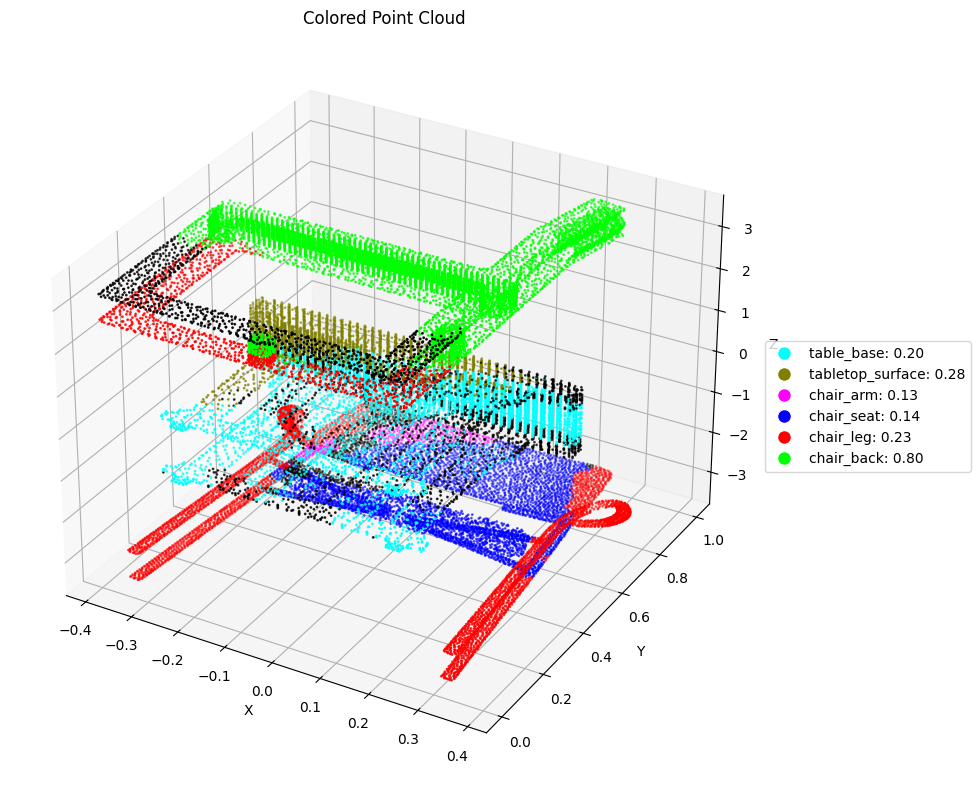

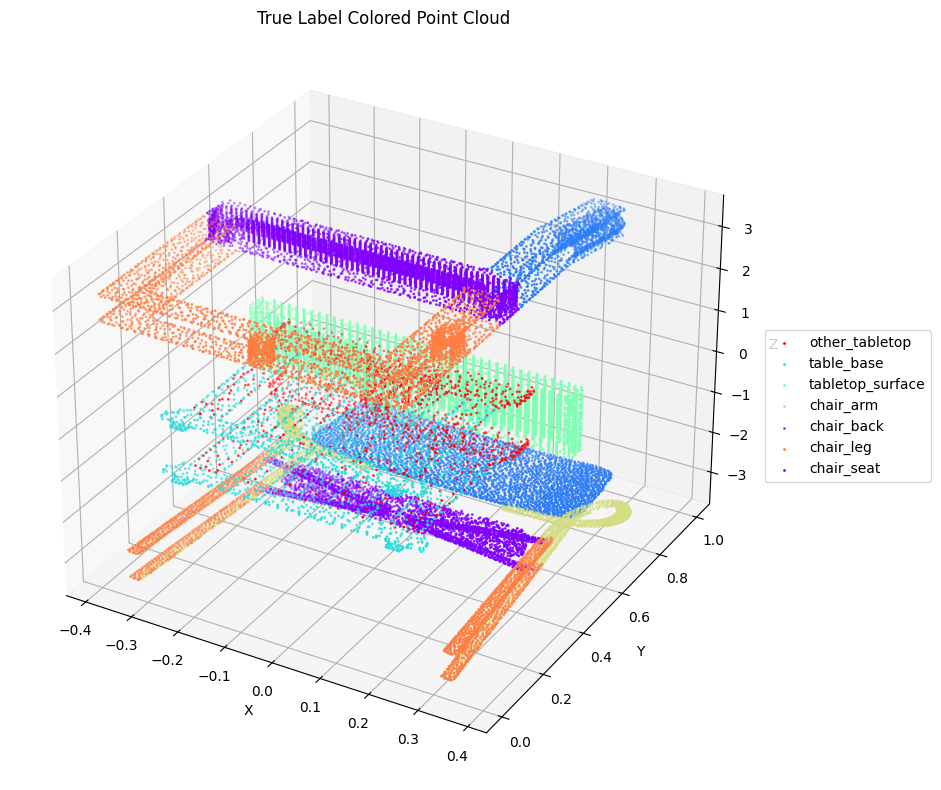

Colored point cloud saved as 'colored_pcd.pcd'


In [13]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_pcd(file_path):
    return o3d.io.read_point_cloud(file_path)

def load_binary_mask(file_path):
    return np.loadtxt(file_path, dtype=bool)

def parse_summary(file_path):
    summary = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                file, label, score = parts
                summary[file.split('/')[-1]] = (int(label), float(score))
    return summary

def plot_colored_pcd_matplotlib_pred(points, colors, label_color_map, label2part):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=1)
    
    # Create a legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f"{label2part[label]}: {score:.2f}",
                                  markerfacecolor=tuple(color), markersize=10)
                       for label, (color, score) in label_color_map.items()]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Colored Point Cloud')
    plt.tight_layout()
    plt.show()

def create_color_map(label2part):
    unique_parts = list(set(label2part.values()))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_parts)))
    part_color_map = dict(zip(unique_parts, colors[:, :3]))  # exclude alpha channel
    return {label: part_color_map[part] for label, part in label2part.items()}

def plot_colored_pcd_matplotlib(pcd, labels, label2part, color_map):
    points = np.asarray(pcd.points)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot points
    for label in np.unique(labels):
        mask = labels == label
        color = color_map[str(int(label))]
        ax.scatter(points[mask, 0], points[mask, 1], points[mask, 2], 
                   c=[color], s=1, label=f"{label2part[str(int(label))]}")

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('True Label Colored Point Cloud')
    
    # Adjust legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

def color_pcd(pcd, labels, color_map):
    point_colors = np.array([color_map[str(int(label))] for label in labels])
    
    colored_pcd = o3d.geometry.PointCloud()
    colored_pcd.points = pcd.points
    colored_pcd.colors = o3d.utility.Vector3dVector(point_colors)
    
    return colored_pcd
def main(scene_id):
    # Load your PCD file
    pcd = scene_pcd
    points = np.asarray(pcd.points)

    # Parse summary
    summary_file = f"/home/wan/Workplace-why/Point-SAM/part_scene_results/{scene_id}/{scene_id}_part_summary.txt"  # Replace with your actual summary file path
    summary = parse_summary(summary_file)

    # Label dictionary
    part_label_v1 = {
        'chair_leg': 0, 'chair_back': 1, 'chair_seat': 2, 'other_tabletop': 3,
        'chair_arm': 4, 'table_base': 5, 'tabletop_surface': 6, 'pillow': 7,
        'table_shelf': 8, 'chair_decoration': 9
    }
    label2part = {v: k for k, v in part_label_v1.items()}

    # List of binary mask files


    # Prepare colors
    colors = np.array([
        [1, 0, 0],    # Red
        [0, 1, 0],    # Green
        [0, 0, 1],    # Blue
        [1, 1, 0],    # Yellow
        [1, 0, 1],    # Magenta
        [0, 1, 1],    # Cyan
        [0.5, 0.5, 0],  # Olive
        [0.5, 0, 0.5],  # Purple
        [0, 0.5, 0.5],  # Teal
        [0.5, 0.5, 0.5]  # Gray
    ])
    
    # Initialize color array and label-color map
    point_colors = np.zeros((len(points), 3))
    label_color_map = {}

    # Load masks and apply colors
    for mask_file in part_masks_path:
        mask = load_binary_mask(mask_file)
        file_name = mask_file.split('/')[-1]
        label, score = summary[file_name]
        color = colors[label]
        point_colors[mask] = color
        label_color_map[label] = (color, score)

    # Create a new colored point cloud
    colored_pcd_pred = o3d.geometry.PointCloud()
    colored_pcd_pred.points = o3d.utility.Vector3dVector(points)
    colored_pcd_pred.colors = o3d.utility.Vector3dVector(point_colors)

    # Visualize using Open3D
    # o3d.visualization.draw_geometries([colored_pcd])

    # Visualize using Matplotlib
    plot_colored_pcd_matplotlib_pred(points, point_colors, label_color_map, label2part)


    #
    color_map_gt = create_color_map(gt_dict)
    colored_pcd_gt = color_pcd(pcd, scene_gt, color_map_gt)

    #plot the gt
    plot_colored_pcd_matplotlib(pcd, scene_gt, gt_dict, color_map_gt)
    # Save the colored point cloud
    # o3d.io.write_point_cloud("colored_pcd.pcd", colored_pcd)

    return colored_pcd_gt,colored_pcd_pred

if __name__ == "__main__":
    colored_pcd_gt,colored_pcd_pred = main(scene_id)
    print("Colored point cloud saved as 'colored_pcd.pcd'")

In [26]:
points = np.asarray(colored_pcd.points)

plot_colored_pcd_matplotlib(points,  scene_gt,  gt_dict)

NameError: name 'colored_pcd' is not defined